In [1]:
import numpy as np
import sklearn
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('datasets/FPU3_ML.csv')

In [3]:
df.columns

Index(['field', ' time', ' ra', ' dec', ' az', ' alt', ' airmass', ' ha',
       ' FU1_ra', ' FU1_dec', ' FU1_Delta_ra', ' FU1_Delta_dec',
       ' FU1_distance', ' FU1_Delta_Teff', ' FU1_X_calculated',
       ' FU1_Y_calculated', ' FU1_X_observed', ' FU1_Y_observed', ' FU2_ra',
       ' FU2_dec', ' FU2_Delta_ra', ' FU2_Delta_dec', ' FU2_distance',
       ' FU2_Delta_Teff', ' FU2_X_calculated', ' FU2_Y_calculated',
       ' FU2_X_observed', ' FU2_Y_observed', ' FU3_ra', ' FU3_dec',
       ' FU3_Delta_ra', ' FU3_Delta_dec', ' FU3_distance', ' FU3_Delta_Teff',
       ' FU3_X_calculated', ' FU3_Y_calculated', ' FU3_X_observed',
       ' FU3_Y_observed', ' FU4_ra', ' FU4_dec', ' FU4_Delta_ra',
       ' FU4_Delta_dec', ' FU4_distance', ' FU4_Delta_Teff',
       ' FU4_X_calculated', ' FU4_Y_calculated', ' FU4_X_observed',
       ' FU4_Y_observed', ' FU5_ra', ' FU5_dec', ' FU5_Delta_ra',
       ' FU5_Delta_dec', ' FU5_distance', ' FU5_Delta_Teff',
       ' FU5_X_calculated', ' FU5_Y_calculate

In [4]:
# Columns have extra spaces; let's correct that (and remove field, just to keep a fully numeric dataframe; why?)
df = pd.DataFrame(df.values[:, 1:], columns=df.columns.str.strip(' ')[1:], dtype='float64')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421 entries, 0 to 420
Data columns (total 57 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   time              421 non-null    float64
 1   ra                421 non-null    float64
 2   dec               421 non-null    float64
 3   az                421 non-null    float64
 4   alt               421 non-null    float64
 5   airmass           421 non-null    float64
 6   ha                421 non-null    float64
 7   FU1_ra            421 non-null    float64
 8   FU1_dec           421 non-null    float64
 9   FU1_Delta_ra      421 non-null    float64
 10  FU1_Delta_dec     421 non-null    float64
 11  FU1_distance      421 non-null    float64
 12  FU1_Delta_Teff    421 non-null    float64
 13  FU1_X_calculated  421 non-null    float64
 14  FU1_Y_calculated  421 non-null    float64
 15  FU1_X_observed    421 non-null    float64
 16  FU1_Y_observed    421 non-null    float64
 1

In [6]:
df.describe().loc[: , ['FU1_X_calculated', 'FU2_X_calculated', 'FU3_X_calculated', 'FU4_X_calculated']]

,FU1_X_calculated,FU2_X_calculated,FU3_X_calculated,FU4_X_calculated
count,4.210000e+02,4.210000e+02,4.210000e+02,4.210000e+02
mean,-1.620872e+06,-1.644148e+06,-3.055527e+05,-1.616355e+06
std,1.086876e+07,9.789309e+06,1.042851e+07,9.674756e+06
min,-2.158133e+07,-2.039550e+07,-2.158919e+07,-2.284561e+07
25%,-8.585121e+06,-8.437881e+06,-6.647917e+06,-5.361752e+06
50%,-1.958671e+06,-3.636617e+06,1.662090e+05,-3.537894e+06
75%,2.659402e+06,4.903942e+06,6.446577e+06,2.822972e+06
max,2.268384e+07,2.348568e+07,2.257321e+07,2.227233e+07


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1265daca0>,
      dtype=object)

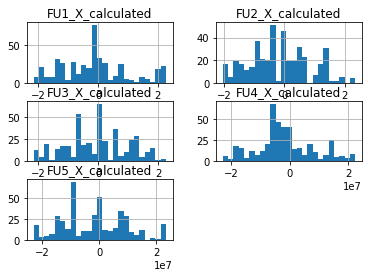

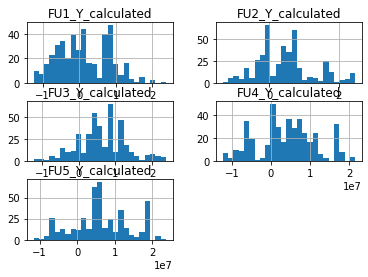

In [7]:
df.hist(['FU1_X_calculated', 'FU2_X_calculated', 'FU3_X_calculated', 'FU4_X_calculated', 'FU5_X_calculated'], bins=25)
df.hist(['FU1_Y_calculated', 'FU2_Y_calculated', 'FU3_Y_calculated', 'FU4_Y_calculated', 'FU5_Y_calculated'], bins=25)

In [8]:
# Compute X and Y differences for each arm
for i in range(1, 6):
    for d in ['X', 'Y']:
        df['FU{}_d{}'.format(i, d)] = df['FU{}_{}_observed'.format(i, d)] - df['FU{}_{}_calculated'.format(i, d)]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1242d49d0>,
      dtype=object)

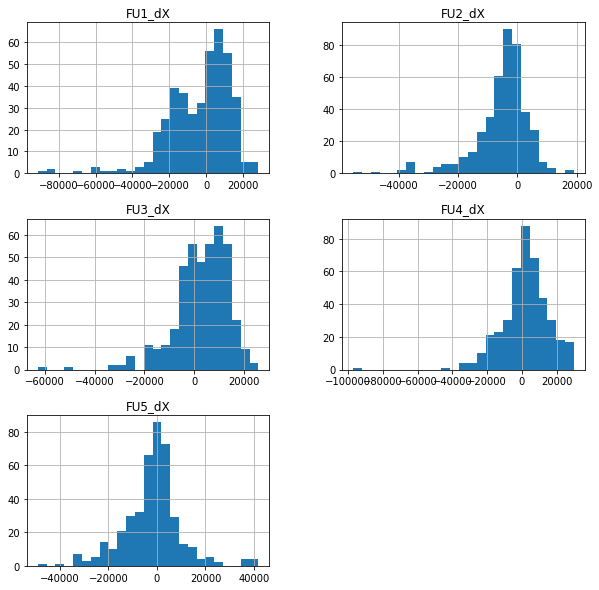

In [9]:
df.hist(['FU1_dX', 'FU2_dX', 'FU3_dX', 'FU4_dX', 'FU5_dX'], bins=25, figsize=(10, 10))

In [10]:
# Drop some columns
cols_to_drop = []

for i in range(1, 6):
    for d in ['X', 'Y']:
        cols_to_drop.append('FU{}_{}_observed'.format(i, d))
        
df2 = df.drop(labels=cols_to_drop, axis=1, inplace=False)

In [11]:
df2.corr(method='spearman').FU1_dX.abs().sort_values(ascending=False)

FU1_dX              1.000000
FU2_dX              0.457388
FU5_dX              0.429320
ha                  0.402275
FU1_Y_calculated    0.324577
FU1_Delta_dec       0.322336
FU4_dX              0.312687
FU4_Delta_ra        0.304430
alt                 0.266297
airmass             0.266297
FU2_dY              0.262074
FU3_X_calculated    0.244615
FU5_dec             0.240809
FU3_dec             0.240049
FU4_dec             0.239456
dec                 0.239385
FU2_dec             0.239256
FU1_dec             0.237994
FU3_Delta_dec       0.233684
FU3_Delta_Teff      0.221702
FU5_Delta_Teff      0.219737
az                  0.199332
FU2_Delta_Teff      0.183116
FU2_Delta_dec       0.178279
FU4_distance        0.175818
FU4_X_calculated    0.175272
FU2_X_calculated    0.164635
FU5_distance        0.156026
FU3_Delta_ra        0.154784
FU4_dY              0.150881
FU2_Delta_ra        0.141343
FU5_Delta_ra        0.117995
FU2_Y_calculated    0.108699
FU5_dY              0.097509
FU1_dY        

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/collections.py:886: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


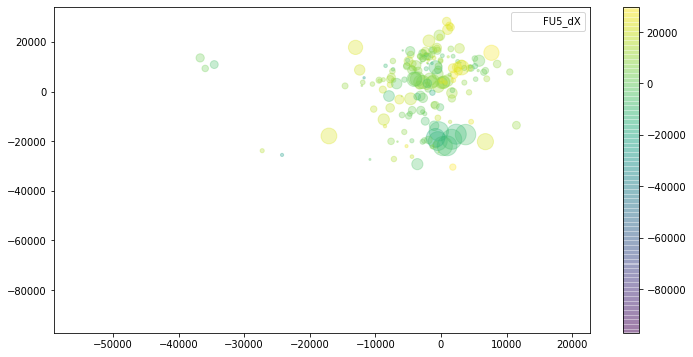

In [12]:
plt.figure(figsize=(12, 6))
plt.scatter(df2.FU2_dX, df2.FU1_dX, s=df2.FU5_dX/1e2, c=df2.FU4_dX, alpha=0.3, label='FU5_dX')
plt.legend(loc=0)
plt.colorbar()

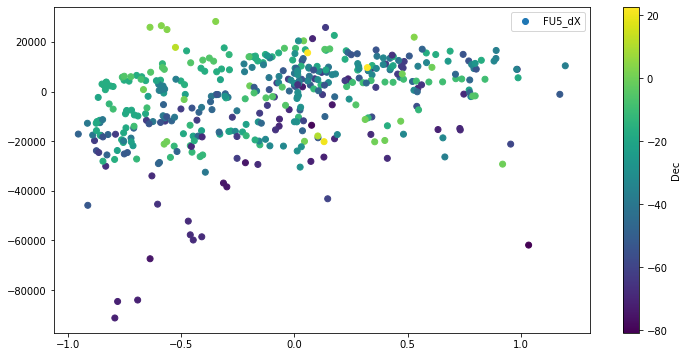

In [13]:
plt.figure(figsize=(12, 6))
plt.scatter(df2.ha, df2.FU1_dX, c=df2.dec, alpha=1, label='FU5_dX')
plt.legend(loc=0)
plt.colorbar(label='Dec')

In [28]:
cond = df2.FU1_dX > -30000

X = df2.loc[cond, ('ha', 'dec', 'airmass', 'alt', 'FU1_Delta_dec', 'FU1_Delta_ra', 'FU1_X_calculated', 'FU1_Y_calculated')]
t = df2.loc[cond, ['FU1_dX', 'FU1_dY']]

In [29]:
t.shape

(403, 2)

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split train test
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.2, random_state=1234)

# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Linear Regression

In [31]:
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(X_train, t_train)

# Metrics
y_train = lr.predict(X_train)

print('RMSE: {:.2f}'.format(np.sqrt(mean_squared_error(t_train, y_train))))

RMSE: 7935.83


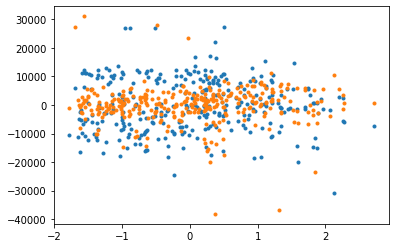

In [32]:
res = t_train - y_train

plt.plot(X_train[:, 0], res, '.')

In [34]:
from utils import hat_matrix
H = hat_matrix(X_train)

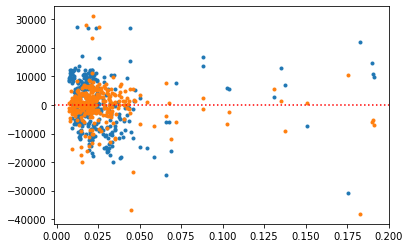

In [35]:
plt.plot(np.diag(H), res, '.')
plt.axhline(0, color='r', ls=':')

**What out for those outliers!**


In [20]:
# Remove high-leverage points
ind = np.diag(H) > 0.05

lr.fit(X_train[~ind], t_train[~ind])
y_train = lr.predict(X_train[~ind])

print('RMSE (train): {:.2f}'.format(np.sqrt(mean_squared_error(t_train[~ind], y_train))))



RMSE (train): 7898.42


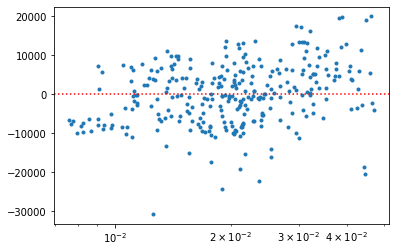

In [21]:
plt.semilogx(np.diag(H)[~ind], y_train - t_train[~ind], '.')
plt.axhline(0, color='r', ls=':')

## Polynomial Regression

In [36]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

pr = LinearRegression(fit_intercept=False)

pr.fit(X_train_poly, t_train)
y_train = pr.predict(X_train_poly)
y_test =  pr.predict(X_test_poly)
print('RMSE (train): {:.2f}'.format(np.sqrt(mean_squared_error(t_train, y_train))))
print('RMSE (test): {:.2f}'.format(np.sqrt(mean_squared_error(t_test, y_test))))

RMSE (train): 4104.77
RMSE (test): 4321.60


In [23]:
X_train_poly.shape

(322, 45)

## Decision Tree

In [37]:
# Let's hit it harder
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(max_depth=7)
dt.fit(X_train, t_train)

# Metrics
y_train = dt.predict(X_train)
y_test = dt.predict(X_test)

print('RMSE (train): {:.2f}'.format(np.sqrt(mean_squared_error(t_train, y_train))))
print('RMSE (test): {:.2f}'.format(np.sqrt(mean_squared_error(t_test, y_test))))

RMSE (train): 3469.36
RMSE (test): 6090.88


In [38]:
from sklearn.model_selection import GridSearchCV

gscv = GridSearchCV(dt, {'max_depth': range(2, 50)}, cv=5, scoring='neg_mean_squared_error')
gscv.fit(X_train, t_train)

print(gscv.best_params_)
print('Best RMSE (train): {:2f}'.format(np.sqrt(-gscv.best_score_)))
print('Best RMSE (test): {:2f}'.format(np.sqrt(mean_squared_error(gscv.best_estimator_.predict(X_test), t_test))))

{'max_depth': 7}
Best RMSE (train): 7357.735075
Best RMSE (test): 6103.711680


## Random Forests

In [39]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=500, n_jobs=6)
rfr.fit(X_train, t_train)

y_train = rfr.predict(X_train)
y_test =  rfr.predict(X_test)
print('RMSE (train): {:.2f}'.format(np.sqrt(mean_squared_error(t_train, y_train))))
print('RMSE (test): {:.2f}'.format(np.sqrt(mean_squared_error(t_test, y_test))))

RMSE (train): 2003.56
RMSE (test): 4996.19


In [ ]:
RandomForestRegressor?

In [40]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

rscv = RandomizedSearchCV(rfr, {'max_depth': randint(2, 20), 'n_estimators': randint(100, 500)}, 
                          n_iter=20, cv=5, scoring='neg_mean_squared_error')
rscv.fit(X_train, t_train)

print(rscv.best_params_)
print('Best RMSE (train): {:2f}'.format(np.sqrt(-rscv.best_score_)))
print('Best RMSE (test): {:2f}'.format(np.sqrt(mean_squared_error(rscv.best_estimator_.predict(X_test), t_test))))

{'max_depth': 14, 'n_estimators': 356}
Best RMSE (train): 5886.965337
Best RMSE (test): 4977.659238


In [41]:
y_train = rscv.best_estimator_.predict(X_train)
y_test = rscv.best_estimator_.predict(X_test)

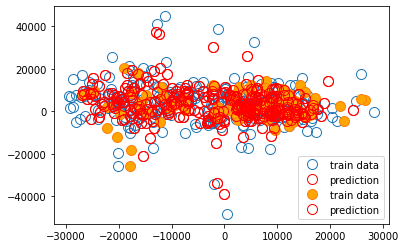

In [66]:
plt.plot(*t_train.values.T, label='train data', mfc='None', marker='o', ms=10, ls='')
plt.plot(*y_train.T, label='prediction', mfc='None', marker='o', color='r', ms=10, ls='')

plt.plot(*t_test.values.T, label='train data', mfc='Orange', marker='o', ms=10, ls='')
plt.plot(*y_train.T, label='prediction', mfc='None', marker='o', color='r', ms=10, ls='')

# plt.scatter(t_test, y_test, label='test data')
plt.legend(loc=0)
# plt.xlabel('FU1_dX [target]', fontsize=16)
# plt.ylabel('FU1_dX [predicted]', fontsize=16)
plt.savefig('/Users/rodrigo/EXOML/extra/plots/RF_run1.pdf')

I am tempted to repeat everything for points >-30000

In [73]:
X.columns[rfr.feature_importances_.argsort()[::-1]]

Index(['FU1_Delta_ra', 'ha', 'dec', 'FU1_X_calculated', 'FU1_Y_calculated',
       'FU1_Delta_dec', 'airmass', 'alt'],
      dtype='object')

In [87]:
print(X.columns[lr.coef_.argsort(axis=1)[::-1][0]])
print(X.columns[lr.coef_.argsort(axis=1)[::-1][1]])

Index(['FU1_Y_calculated', 'FU1_Delta_ra', 'alt', 'airmass', 'dec', 'ha',
       'FU1_X_calculated', 'FU1_Delta_dec'],
      dtype='object')
Index(['FU1_Delta_dec', 'FU1_X_calculated', 'dec', 'airmass', 'alt', 'ha',
       'FU1_Delta_ra', 'FU1_Y_calculated'],
      dtype='object')
